# Cancer image detection

The goal of this notebook is to run through a few models I tested for this skin cancer binary classification task and discuss some of the lessons from this project. I made the decison to stick with using only the VGG16 model as a base for this work because the aim was to learn how to get the best results from a pretrained model rather than compare performance but in future projects, I would certainly compare a few options before developing any further. 

note: all fit statments are commented out so that the notebook may be run quickly. 

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

In [2]:
X_train=np.load('Skin_cancer_X_train.npy')
y_train=np.load('Skin_cancer_y_train.npy')

X_dev=np.load('Skin_cancer_X_dev.npy')
y_dev=np.load('Skin_cancer_y_dev.npy')

## How will I evaluate the models 

I decided to use AUC score as the primary way to compare the models I trained, as the is a standard choice for classification. it is worth noting that my dataset has some mild class imbalance (30% positive class) which will result in AUC being a little optimistic compared to a totally balanced dataset. 

To supliment this metric, I also looked at precison at a recall of 90%. My thinking behind this is that a high recall is likely highly desirable with cancer detection, so we may wonder how well the models perform when this is set. A limitation of this is that there are only 34 positive examples in the dev set, this means that the metric is very sensitive to noise. 

## VGG16 basic model

The first model I tested is simply a VGG16 base (which I kept untrainable) with global average pooling then a sigmoid layer. We can think of this model as though it is simply logisitic regression glued onto the VGG16 model, which is surprisingly effective considering the relative simplicity of this model. There is noticable overfitting.

In [50]:
VVG16_base=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,)

VVG16_base.trainable=False 

In [51]:
VVG16_model=tf.keras.Sequential([
    VVG16_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1,activation='sigmoid')])

In [52]:
VVG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.PrecisionAtRecall(0.9)])

In [53]:
#history=VVG16_model.fit(X_train, y_train,epochs=10, validation_data=(X_dev,y_dev))

In [54]:
#np.save('basic_VGG16_model.npy',history.history)

In [55]:
loaded_history=np.load('basic_VGG16_model.npy',allow_pickle=True).item()

In [56]:
print(max(loaded_history['val_auc']))

0.9155308604240417


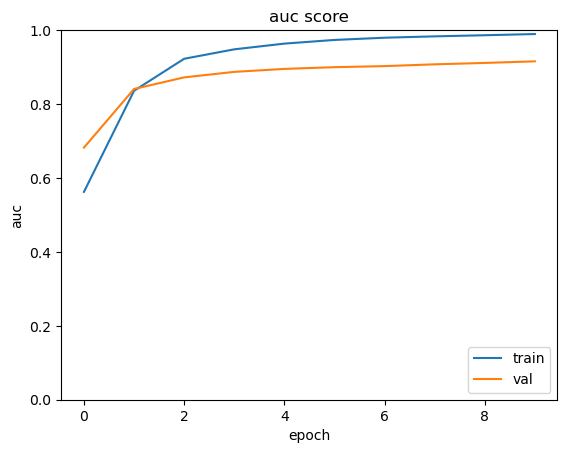

In [57]:
plt.figure()
plt.plot(loaded_history['auc'])
plt.plot(loaded_history['val_auc'])
plt.title('auc score')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.ylim([0, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

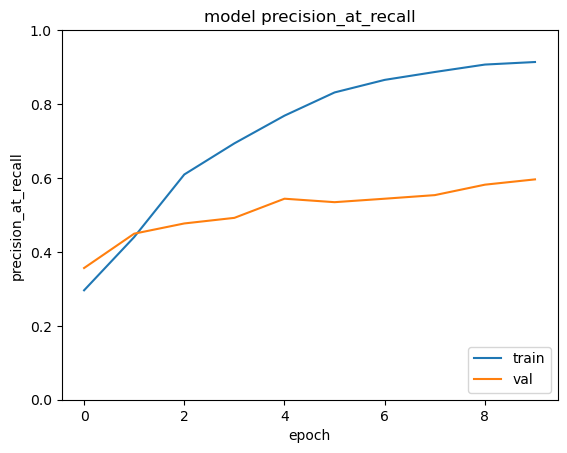

In [12]:
plt.figure()
plt.plot(loaded_history['precision_at_recall'])
plt.plot(loaded_history['val_precision_at_recall'])
plt.title('model precision_at_recall')
plt.ylabel('precision_at_recall')
plt.xlabel('epoch')
plt.ylim([0, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [13]:
#commented out as this requires model.fit to have been run
'''predict=VVG16_model.predict(X_dev)
precision, recall, _ = precision_recall_curve(y_dev, predict)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()'''

'predict=VVG16_model.predict(X_dev)\nprecision, recall, _ = precision_recall_curve(y_dev, predict)\npr_display = PrecisionRecallDisplay(precision=precision, recall=recall)\npr_display.plot()'

In [14]:
tf.keras.backend.clear_session()

## VGG16 with dropout 

My first experiment to tackle the overfitting, seen in the basic model, was to add dropout to the layers I've added to the VGG16 base. This was reasonably sucessful at reducing overfitting, although the model performance no longer improved so consistently. I tuned a few different values of dropout, with the 0.3 here giving the best balance between bias and varience.

In [15]:
VVG16_model_dropout=tf.keras.Sequential([
    VVG16_base,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1,activation='sigmoid')])

In [16]:
VVG16_model_dropout.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.PrecisionAtRecall(0.90)])

In [17]:
#history=VVG16_model_dropout.fit(X_train, y_train,epochs=20, validation_data=(X_dev,y_dev))

In [18]:
#np.save('VGG16_model_drop_0.3.npy',history.history)

In [19]:
loaded_history=np.load('VGG16_model_drop_0.3.npy',allow_pickle=True).item()

In [20]:
print(max(loaded_history['val_auc']))

0.9413557648658752


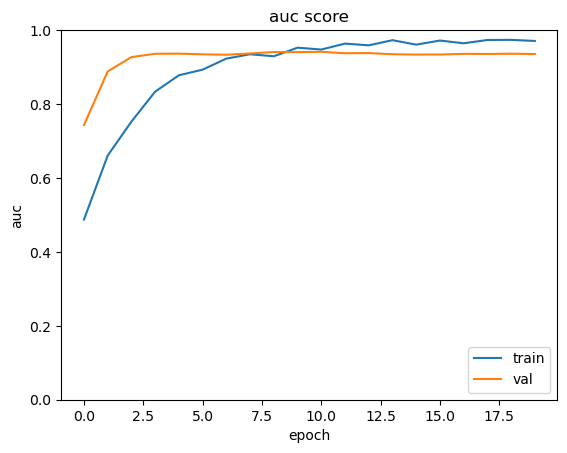

In [21]:
plt.figure()
plt.plot(loaded_history['auc'])
plt.plot(loaded_history['val_auc'])
plt.title('auc score')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.ylim([0, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

The inconsitent performance across the trainin epochs is very visible when looking at precison at recall. 

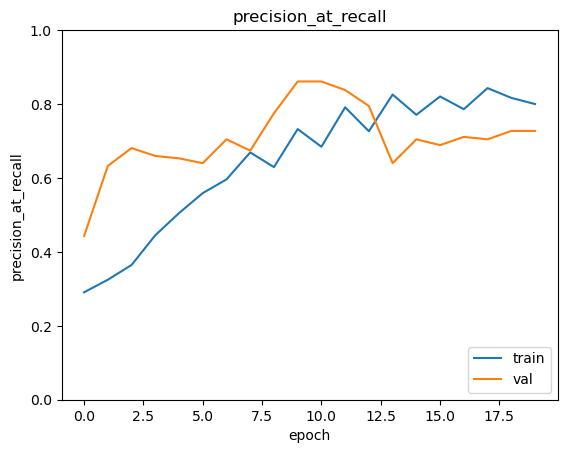

In [22]:
plt.figure()
plt.plot(loaded_history['precision_at_recall'])
plt.plot(loaded_history['val_precision_at_recall'])
plt.title('precision_at_recall')
plt.ylabel('precision_at_recall')
plt.xlabel('epoch')
plt.ylim([0, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [23]:
#commented out as this requires model.fit to have been run
'''predict=VVG16_model_dropout.predict(X_dev)
precision, recall, _ = precision_recall_curve(y_dev, predict)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()'''

'predict=VVG16_model_dropout.predict(X_dev)\nprecision, recall, _ = precision_recall_curve(y_dev, predict)\npr_display = PrecisionRecallDisplay(precision=precision, recall=recall)\npr_display.plot()'

In [24]:
tf.keras.backend.clear_session()

## VGG16 with regularisation

Now we come to one of the more successful models I trained. If we view the VGG16 model as generating features for a logistic regression model, we realise, we are trying to use 25088 features for this final layer. Thinking about it like that, it's really not surprising that we end up with high variance. The obvious solution would be to reduce the number of features we are using, to practiacally do this we are looking at L1 regularisation (which punishes using too many features).

Tuning this hyperparameter resulted in 0.1 giving the best trade off between bias and variance of the values I experimented with. To improve this model I would next be looking at reducing bias, although in order to get a better sense how much bias is avoidable, I would need to know what human level performance for this task. 

In [25]:
VVG16_model_reg=tf.keras.Sequential([
    VVG16_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.L1(0.1)),
    tf.keras.layers.Activation('sigmoid')])

In [26]:
VVG16_model_reg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.PrecisionAtRecall(0.9)])

In [27]:
#history=VVG16_model_reg.fit(X_train, y_train,epochs=20, validation_data=(X_dev,y_dev))

In [28]:
#np.save('VGG16_model_L1_0.1.npy',history.history)

In [29]:
loaded_history=np.load('VGG16_model_L1_0.1.npy',allow_pickle=True).item()

In [30]:
print(max(loaded_history['val_auc']))

0.9393830299377441


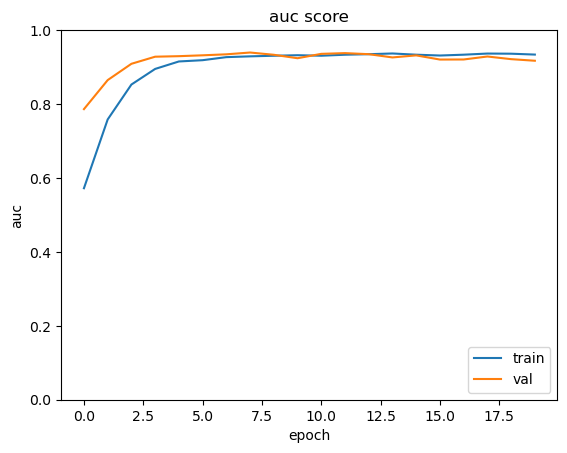

In [31]:
plt.figure()
plt.plot(loaded_history['auc'])
plt.plot(loaded_history['val_auc'])
plt.title('auc score')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.ylim([0, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

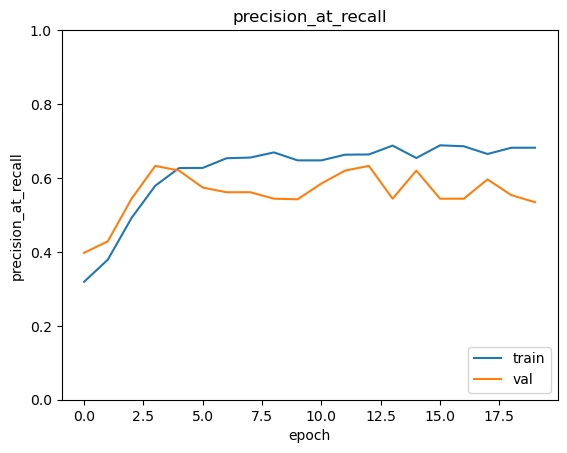

In [32]:
plt.figure()
plt.plot(loaded_history['precision_at_recall'])
plt.plot(loaded_history['val_precision_at_recall'])
plt.title('precision_at_recall')
plt.ylabel('precision_at_recall')
plt.xlabel('epoch')
plt.ylim([0, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [33]:
#commented out as this requires model.fit to have been run
'''predict=VVG16_model_reg.predict(X_dev)
precision, recall, _ = precision_recall_curve(y_dev, predict)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()'''

'predict=VVG16_model_reg.predict(X_dev)\nprecision, recall, _ = precision_recall_curve(y_dev, predict)\npr_display = PrecisionRecallDisplay(precision=precision, recall=recall)\npr_display.plot()'

In [58]:
tf.keras.backend.clear_session()

## A more complex model 

Finally, I experimented with a few deeper models, in the hope of reducing the bias while ideally not introducing variance. With some architechtures, I was able to get similar performance to the regularised model I tested previously, but nothing significantly better.

I would be interested to experiment a bit further here but one lesson I took away was that in this situation, the simpler approach was quite effective.,

In [59]:
VVG16_deeper_model=tf.keras.Sequential([
    VVG16_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(100,kernel_regularizer=tf.keras.regularizers.L1(0.05)),
    tf.keras.layers.Dense(10,kernel_regularizer=tf.keras.regularizers.L1(0.05)),
    tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.L1(0.05)),
    tf.keras.layers.Activation('sigmoid')])

In [60]:
VVG16_deeper_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.PrecisionAtRecall(0.9)])

In [61]:
#history=VVG16_deeper_model.fit(X_train, y_train,epochs=20, validation_data=(X_dev,y_dev))

Epoch 1/20
43/43 [==============================] - 90s 2s/step - loss: 92.2534 - auc: 0.8199 - precision_at_recall: 0.3746 - val_loss: 54.8414 - val_auc: 0.9042 - val_precision_at_recall: 0.5500
Epoch 2/20
43/43 [==============================] - 90s 2s/step - loss: 31.4251 - auc: 0.9469 - precision_at_recall: 0.6897 - val_loss: 13.9877 - val_auc: 0.8899 - val_precision_at_recall: 0.5714
Epoch 3/20
43/43 [==============================] - 90s 2s/step - loss: 8.6990 - auc: 0.9602 - precision_at_recall: 0.7595 - val_loss: 5.8843 - val_auc: 0.8691 - val_precision_at_recall: 0.5082
Epoch 4/20
43/43 [==============================] - 90s 2s/step - loss: 4.5512 - auc: 0.9502 - precision_at_recall: 0.6990 - val_loss: 3.6825 - val_auc: 0.8635 - val_precision_at_recall: 0.5439
Epoch 5/20
43/43 [==============================] - 91s 2s/step - loss: 3.0364 - auc: 0.9290 - precision_at_recall: 0.6115 - val_loss: 2.6155 - val_auc: 0.8657 - val_precision_at_recall: 0.5082
Epoch 6/20
43/43 [========

In [62]:
#np.save('VVG16_deepest_model_L1_0.05.npy',history.history)

In [63]:
loaded_history=np.load('VVG16_deepest_model_L1_0.05.npy',allow_pickle=True).item()

In [64]:
print(max(loaded_history['val_auc']))

0.9114060401916504


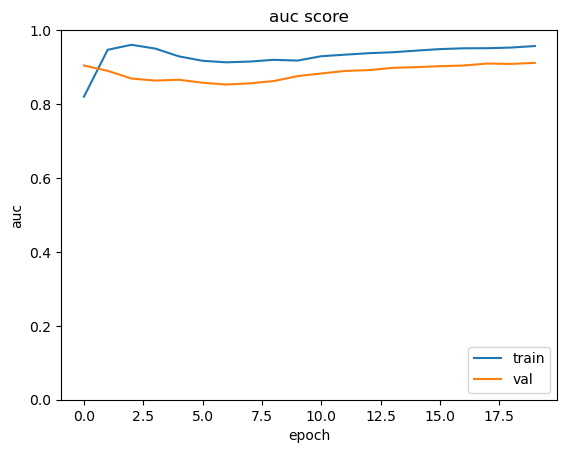

In [65]:
plt.figure()
plt.plot(loaded_history['auc'])
plt.plot(loaded_history['val_auc'])
plt.title('auc score')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.ylim([0, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

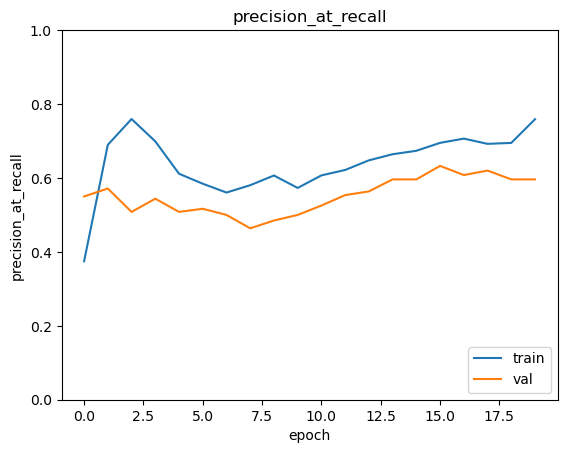

In [66]:
plt.figure()
plt.plot(loaded_history['precision_at_recall'])
plt.plot(loaded_history['val_precision_at_recall'])
plt.title('precision_at_recall')
plt.ylabel('precision_at_recall')
plt.xlabel('epoch')
plt.ylim([0, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [43]:
#commented out as this requires model.fit to have been run
'''predict=VVG16_deeper_model.predict(X_dev)
precision, recall, _ = precision_recall_curve(y_dev, predict)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()'''

'predict=VVG16_deeper_model.predict(X_dev)\nprecision, recall, _ = precision_recall_curve(y_dev, predict)\npr_display = PrecisionRecallDisplay(precision=precision, recall=recall)\npr_display.plot()'